<a id="top"></a>
# Land Change

<hr>

# Notebook Summary

This notebook uses changes in NDVI, EVI or Fractional Cover to identify land change. 
The algorithm identifies a "baseline" and "analysis" time period and then compares 
the spectral parameters in each of those time periods. Significant reductions in 
vegetation are coincident with land change. In some cases these changes could be 
deforestation. Users of this algorithm should not accept the accuracy of the results 
but should conduct ground validation testing to assess accuracy. In most cases, these 
algorithms can be used to identify clusters of pixels that have experienced change and 
allow targeted investigation of those areas by local or regional governments.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Define Analysis Parameters](#define_analysis_params)
* [Load, Clean, and Mosaic Data from the Data Cube](#load_data)
* [Show Baseline Composite, Analysis Composite, and Anomaly Products](#composites_anomaly)
* [Calculate Pixel Counts within Thresholds](#threshold_counts)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [22]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

from datacube.utils.aws import configure_s3_access
configure_s3_access(requester_pays=True)

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [37]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = 'ls7_usgs_sr_scene'
# platform = 'LANDSAT_7'
# collection = 'c1'
# level = 'l2'

product = 'ls8_usgs_sr_scene'
platform = 'LANDSAT_8'
collection = 'c1'
level = 'l2'

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [24]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.633472222323288, 12.623472222323212)
Longitude Extents: (-14.630416666783711, 44.009861111463195)
Time Extents: ['2013-03-21', '2020-01-27']


**Visualize the available area**

In [25]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [26]:
# Select an analysis region 

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Nairobi, Kenya
latitude = (-1.4347, -1.151) 
longitude = (36.6985, 36.9978) 

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Phu Thuy, Vietnam
# latitude = (10.8945, 10.9679)
# longitude = (108.0616, 108.1460)

**Visualize the selected area**

In [27]:
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [57]:
# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = ("2015-01-01", "2015-01-30")

# Select the analysis time period (start and end)
analysis_time_period = ("2017-01-01", "2017-01-30")

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses
# HINT: Consider max_ndvi mosaics for NDVI analyses and median mosaics for EVI analyses 

baseline_mosaic_function = "median" 
analysis_mosaic_function = "median" 

## <span id="load_data">Load, Clean, and Mosaic Data from the Data Cube [&#9652;](#top)</span>

>#### Load Data (Baseline, Analysis) 

In [58]:
import datacube
name = "land change"
version = 1
dc = datacube.Datacube(app = f"{name}_v{version}")

common_load_params = dict(latitude = latitude, longitude = longitude,
                          measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"],
                          product = product, platform = platform,
                          group_by='solar_day', 
                          dask_chunks={'time':1})

In [76]:
baseline_ds = dc.load(**common_load_params, 
                      time = baseline_time_period)

In [77]:
analysis_ds = dc.load(**common_load_params, 
                      time = analysis_time_period)

> #### Check if loads are valid

In [61]:
from utils.data_cube_utilities.dc_load import is_dataset_empty

In [78]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [79]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

> #### Clean Data
> Generating boolean masks that highlight valid pixels.
> Pixels must be cloud-free over land or water to be kept.

In [83]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

plt_col_lvl_params = dict(platform=platform, collection=collection, level=level)
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, **plt_col_lvl_params)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, **plt_col_lvl_params)

In [84]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

>#### Mosaic
> Use clean masks in a time series composite

In [85]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic

mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [86]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [88]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask).persist()
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask).persist()

## <span id="composites_anomaly">Show Baseline Composite, Analysis Composite, and Anomaly Products [&#9652;](#top)</span>

In [72]:
from utils.data_cube_utilities.vegetation import NDVI, EVI
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify

# Select these two lines for NDVI
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)

# Select these two lines for EVI
# parameter_baseline_composite = EVI(baseline_composite)
# parameter_analysis_composite = EVI(analysis_composite)

# Select these two lines for Fractional Cover (FC)
# parameter_baseline_composite = frac_coverage_classify(baseline_composite).pv
# parameter_analysis_composite = frac_coverage_classify(analysis_composite).pv 

In [89]:
parameter_anomaly = (parameter_analysis_composite - parameter_baseline_composite).persist()

In [90]:
import matplotlib.pyplot as plt
from utils.data_cube_utilities.dc_rgb import rgb
from matplotlib.cm import RdYlGn, Greens
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

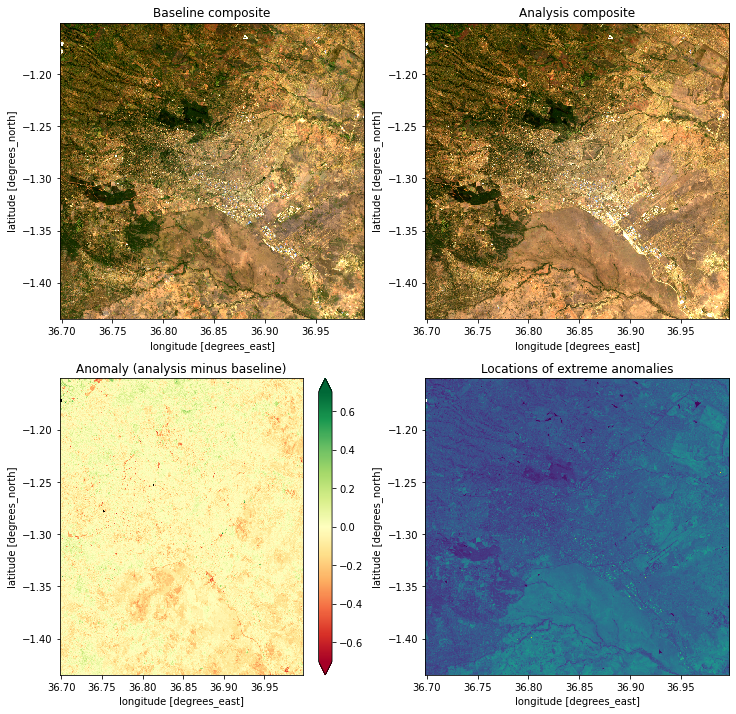

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

baseline_rgb = baseline_composite[['red', 'green', 'blue']].to_array().chunk({'variable': -1})
analysis_rgb = analysis_composite[['red', 'green', 'blue']].to_array().chunk({'variable': -1})

# Use the middle values of the data (2% to 98%) to brighten the image
rgb_vmin = min(baseline_rgb.quantile(0.02).data,analysis_rgb.quantile(0.02).data)
rgb_vmax = max(baseline_rgb.quantile(0.98).data,analysis_rgb.quantile(0.98).data)

# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold
baseline_rgb.plot.imshow(ax=ax[0,0], vmin=rgb_vmin, vmax=rgb_vmax)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=rgb_vmin, vmax=rgb_vmax)
parameter_anomaly.plot(ax=ax[1,0], vmin=-0.7, vmax=0.7, cmap = RdYlGn)
analysis_composite['swir1'].plot.imshow(ax=ax[1,1], add_colorbar=False)

# Titles
ax[0,0].set_title('Baseline composite')
ax[0,1].set_title('Analysis composite')
ax[1,0].set_title('Anomaly (analysis minus baseline)')
ax[1,1].set_title('Locations of extreme anomalies')

plt.show()

## <span id="threshold_counts">Calculate Pixel Counts within Thresholds [&#9652;](#top)</span>

In [92]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [93]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# Losses are typically in these ranges for deforestation
# NDVI: -0.1 to -0.7
# Fractional Cover PV: -20 to -70

minimum_change = -0.7
maximum_change = -0.1

In [94]:
# This output is a count of the pixels that fall within each threshold range

threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 1101716,
 'total_non_cloudy': 1101548,
 'inside': 208791,
 'outside': 892757}

In [95]:
# This output is a percentage of the pixels that fall within each threshold range

threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 18.951435760214068,
 'percent_outside_threshold': 81.03331530085794,
 'percent_clouds': 0.015248938927996392}

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [96]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr
from pathlib import Path

# Remove the comment tag # to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# There are 3 possible outputs ... baseline mosaic, analysis mosaic, or anomaly product

output_dir = "../output/geotiffs"
path = Path(output_dir)
path.mkdir(parents=True, exist_ok=True)

# Export baseline composite.
# write_geotiff_from_xr(output_dir + "/sample_baseline_01.tif", bands = ['red','green','blue','nir','swir1','swir2'], baseline_composite)
# Export analysis composite.
# write_geotiff_from_xr(output_dir + "/sample_analysis_01.tif", bands = ['red','green','blue','nir','swir1','swir2'], analysis_composite)
# Export anomaly product.
write_geotiff_from_xr(output_dir + "/sample_anomaly_01.tif", parameter_anomaly.to_dataset(name='pv'), bands=['pv'])

In [97]:
!ls -lah ../output/geotiffs/*.tif

-rw-r--r-- 1 jovyan users 8.5M Feb  9 16:39 ../output/geotiffs/sample_anomaly_01.tif
